# MovingBox Intermediate Frame Prediction by LSTM

In [1]:
import sys
sys.path.append('..')
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from IPython import display
import numpy as np
from util.tf_ops import *
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image
import tensorflow.contrib.rnn as rnn

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Load Train and Test Data

In [2]:
train_collection =  get_collection("../data/road-128x128/train")
# train_collection = augment_reverse_color(train_collection)
train_collection = center_collections(train_collection)
# total number of images
total_train = sum([x.shape[0] for x in train_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(train_collection), total_train))

{'dim': (188, 128, 128), 'images:': 'road-train-2'}
{'dim': (350, 128, 128), 'images:': 'road-train-1'}
{'dim': (220, 128, 128), 'images:': 'road-train-3'}

After Augmentation: img_collections has 3 collections, 758 images in total


In [3]:
test_collection = get_collection("../data/road-128x128/test")
# test_collection = augment_reverse_color(test_collection)
test_collection = center_collections(test_collection)
# total number of images
total_test = sum([x.shape[0] for x in test_collection])
print("\nAfter Augmentation: Test set has {} collections, {} images in total".format(len(test_collection), total_test))

{'dim': (86, 128, 128), 'images:': 'road-test-1'}
{'dim': (87, 128, 128), 'images:': 'road-test-3'}
{'dim': (80, 128, 128), 'images:': 'road-test-2'}

After Augmentation: Test set has 3 collections, 253 images in total


In [4]:
test_collection[0].shape

(86, 128, 128)

## Sample

In [5]:
def sample(collection, batch_size = 8, gap = 1, seq_size = 3):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        (train_input, train_gd)
        
        train_input: [batch size, seq_size, 32, 32]
        train_gd:    [batch size, seq_size, 32, 32]
    """
    assert gap%2==1, "Gap must be odd !" 
    
    def expand_start_to_seq(start_ind):
        """
        Input:
            start_ind: a number indicating index of start frame
        Output:
            np array of [start_ind, start_ind + gap +1, start_ind + 2*(gap+1) ...]
        """
        return np.array([start_ind + i * (gap + 1) for i in range(seq_size)])
    
    
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # start-index for each class
    start_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(num_per_collection[i] - (gap + 1) * seq_size), avg_num_per_class, replace=False)
            start_ind.append(s)
        except: # if not enough in this class
            print("err")
            start_ind.append(np.array([]))
    selected_classes = [i for i in range(n_collection) if start_ind[i].shape[0]>0]
    train_ind = [[expand_start_to_seq(s) for s in ind] for ind in start_ind] # train indexes for each class
    gd_ind = [[(x + (gap+1)//2) for x in ind_by_class] for ind_by_class in train_ind]
    train_input = np.concatenate([np.stack([collection[i][j] for j in train_ind[i]]) for i in selected_classes], axis = 0)
    train_gd =  np.concatenate([np.stack([collection[i][j] for j in gd_ind[i]]) for i in selected_classes], axis = 0)
    
    train_input, train_gd = train_input[:batch_size], train_gd[:batch_size]
    return train_input, train_gd


def sample_train(batch_size = 8, gap = 1, seq_size = 3): return sample(train_collection, batch_size, gap = gap, seq_size = seq_size)

def sample_test(batch_size = 8, gap = 1, seq_size = 3):  return sample(test_collection, batch_size, gap, seq_size = seq_size)


## Sample of Training Data

Range of Image Piece Value: [-0.8901960784313725, 0.9372549019607843]
seq_input shape:            (4, 3, 128, 128)
seq_gd    shape:            (4, 3, 128, 128)


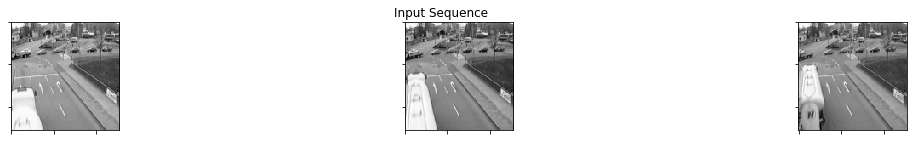

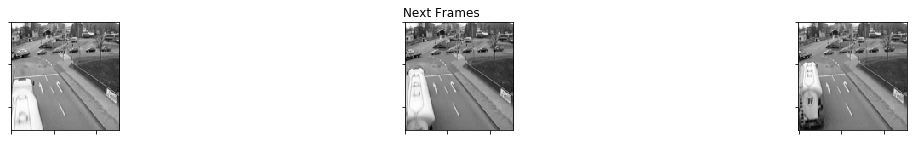

In [6]:
def show_sample_train(batch_size, gap, seq_size):
    seq_input, seq_gd = sample_train(batch_size=batch_size, gap=gap, seq_size= seq_size)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(seq_input), np.max(seq_input)))
    print("seq_input shape:            {}".format(seq_input.shape))
    print("seq_gd    shape:            {}".format(seq_gd.shape))
    selected = np.random.choice(range(batch_size))
    size = (20, 2)
    plot_images_ndarray(seq_input[selected], title="Input Sequence", size = size)
    plot_images_ndarray(seq_gd[selected], title="Next Frames", size = size)
    
show_sample_train(batch_size = 4, gap = 3, seq_size=3)

### Sample of Test Data

Range of Image Piece Value: [-0.6627450980392157, 0.9843137254901961]
seq_input shape:            (2, 5, 128, 128)
seq_gd    shape:            (2, 5, 128, 128)


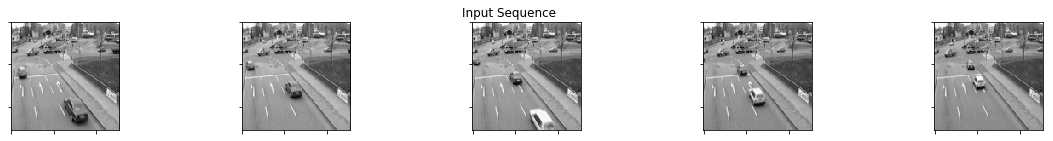

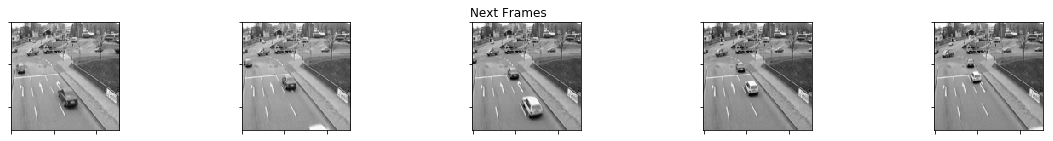

In [7]:
def show_sample_test(batch_size, gap, seq_size):
    seq_input, seq_gd = sample_test(batch_size=batch_size, gap=gap, seq_size= seq_size)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(seq_input), np.max(seq_input)))
    print("seq_input shape:            {}".format(seq_input.shape))
    print("seq_gd    shape:            {}".format(seq_gd.shape))
    selected = np.random.choice(range(batch_size))
    size = (20, 2)
    plot_images_ndarray(seq_input[selected], title="Input Sequence", size = size)
    plot_images_ndarray(seq_gd[selected], title="Next Frames", size = size)
    
show_sample_test(batch_size = 2, gap = 3, seq_size=5)

In [8]:
seq_input, seq_gd = sample_test(batch_size=2, gap=3, seq_size= 6)

In [9]:
np.linalg.norm(seq_input[:, 3, :, :] - seq_gd[:, 2, :, :])

11.631599960755974

# Param

In [102]:
seq_size         = 3

num_iteration    = 2000
gap              = 1
batch_size       = 32
learning_rate    = 2e-4
beta             = 0.7

assert feature_size%64 == 0, "feature_size must be divisable by 64!"
feature_channels = 64

# Encoder

In [89]:
def encode_img(img, is_training=True):
    """
    Input:
        batch size of img
    Output:
        batch size of feature [batch_size, feature_size]
    """
    x = img
    x = tf.reshape(img, [-1, 128, 128, 1])
    
    x = tf.layers.conv2d(x, filters = 64, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters = 64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters = 64, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = feature_channels, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.contrib.layers.flatten(x)
    return x

In [90]:
def encode_seq(img_seq, seq_size = seq_size):
    """
    Input:
        img_seq: sequence of images      Tensor         [batch_size, seq_size, 32, 32]
    Output:
        encoded feature of the sequence  List of Tensor [batch_size, feature_size] of length seq_size
    """
    img_seq = tf.transpose(img_seq, perm=[1, 0, 2, 3]) # [seq_size, batch_size, 32, 32, 1]
    
    return [encode_img(img_seq[i]) for i in range(seq_size)]

# Decoder

In [97]:
def decode(feature, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 8, 8, feature_channel]
    Output:
        batch size of img [batch_size, 32, 32, 1]
    """
    x = tf.reshape(feature, [-1, 16, 16, feature_channels])
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4,  strides=2, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=5,  strides=2, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=3,  strides=1, activation=tf.nn.tanh, padding='same')
    img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    return img

## Loss

In [98]:
def get_loss(gd_imgs, output_imgs):
    """
    Input:
        gd_imgs, output_imgs: [batch_size, seq_size, 8, 8, 1]
    Output:
        scaler loss
    """
    gd_imgs, output_imgs = tf.contrib.layers.flatten(gd_imgs), tf.contrib.layers.flatten(output_imgs)
    return tf.norm(gd_imgs - output_imgs)

In [99]:
def scale_loss(loss, seq_size = seq_size, batch_size = batch_size):
    return loss/seq_size/batch_size/2*255

### Solver

In [100]:
def get_solver(learning_rate=1e-3, beta1=0.5):
    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

## Computation Graph

In [101]:
tf.reset_default_graph()
batch_seq        = tf.placeholder(tf.float32, [None, seq_size, 128, 128])
batch_next       = tf.placeholder(tf.float32, [None, seq_size, 128, 128])
is_training      = tf.placeholder(tf.bool, ())

feature_seq      = encode_seq(batch_seq)
print(feature_seq[0].shape)

# lstm_cell        = rnn.BasicLSTMCell(lstm_state_size)
# output_feature, states = rnn.static_rnn(lstm_cell, feature_seq, dtype=tf.float32)

output_imgs = tf.stack([decode(f) for f in feature_seq], axis = 1)  # [seq_size, batch_size, 32, 32, 1]

loss = get_loss(batch_next, output_imgs)


solver = get_solver(learning_rate, beta)

train_step = solver.minimize(loss)

(?, 16384)


In [103]:
def train(sess, train_step, loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, num_plot = 6):
    losses = []
    for i in range(num_iteration):
        # get a sample
        gap = np.random.choice([1,3])
        seq_input, seq_gd = sample_train(batch_size, gap, seq_size = seq_size)
        dic = {batch_seq: seq_input, batch_next: seq_gd, is_training: True}
        
        sess.run([train_step], dic)
        curr_loss = sess.run(loss, dic)
        curr_loss = scale_loss(curr_loss)# tweek loss to match report loss
        
        losses.append(curr_loss)
    
        if i%show_loss_every ==0:
            print("Iteration {}:  loss = {} | Gap = {}".format(i, curr_loss, gap))
            
        if i%plot_every == 0:
            seq_input, seq_gd = sample_train(1, gap, seq_size = seq_size)
            seq_generated = sess.run(output_imgs, feed_dict=\
                                      {batch_seq: seq_input, batch_next: seq_gd, is_training: False})
            seq_generated = seq_generated[0]
            plot_batch_images(seq_generated[:num_plot], (16, 2) , "Iteration: {} | gap = {}".format(i + plot_every, gap))
    return losses

# Train

Iteration 0:  loss = 495.1927924156189 | Gap = 3


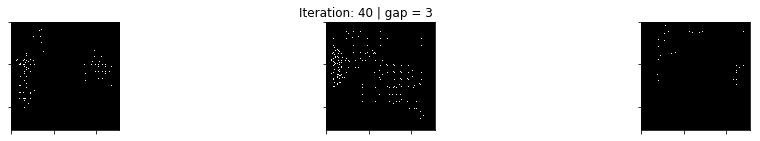

Iteration 40:  loss = 332.16403007507324 | Gap = 3


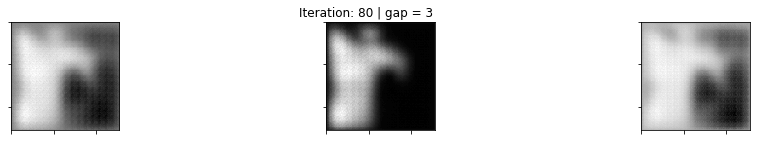

Iteration 80:  loss = 272.7272951602936 | Gap = 3


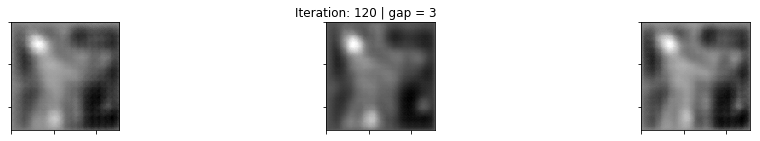

Iteration 120:  loss = 234.3793272972107 | Gap = 3


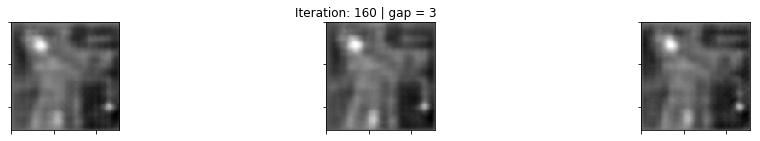

Iteration 160:  loss = 217.72989749908447 | Gap = 3


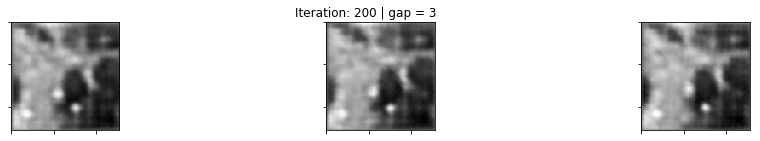

Iteration 200:  loss = 201.39989376068115 | Gap = 1


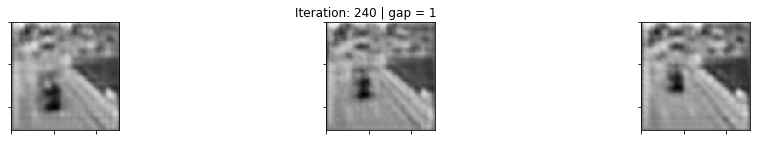

Iteration 240:  loss = 194.5899498462677 | Gap = 1


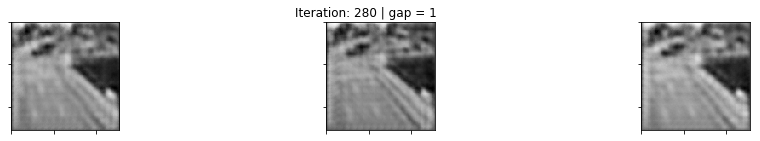

Iteration 280:  loss = 189.31901454925537 | Gap = 1


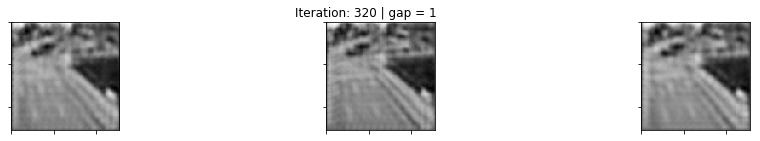

Iteration 320:  loss = 180.44451475143433 | Gap = 1


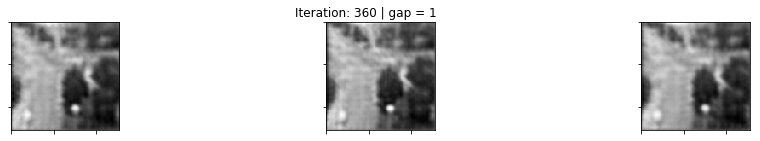

Iteration 360:  loss = 172.97855377197266 | Gap = 1


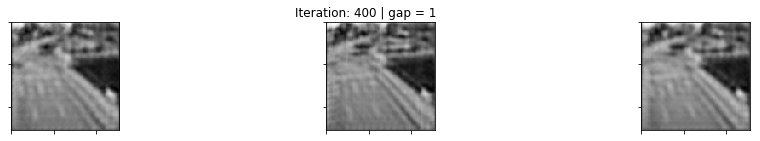

Iteration 400:  loss = 173.29838514328003 | Gap = 3


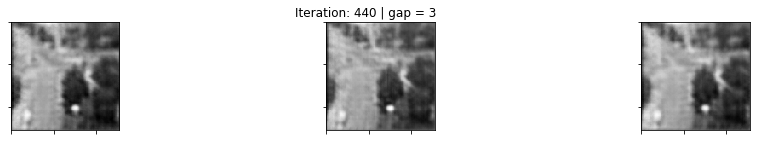

Iteration 440:  loss = 171.98795199394226 | Gap = 3


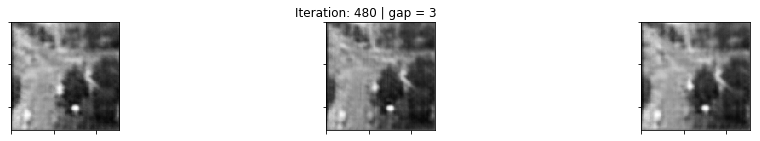

Iteration 480:  loss = 161.16820991039276 | Gap = 1


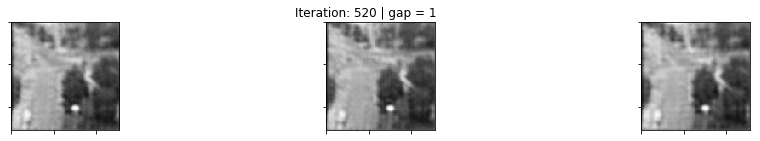

Iteration 520:  loss = 157.58085787296295 | Gap = 1


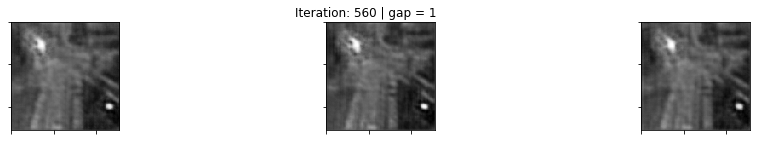

Iteration 560:  loss = 155.93766391277313 | Gap = 1


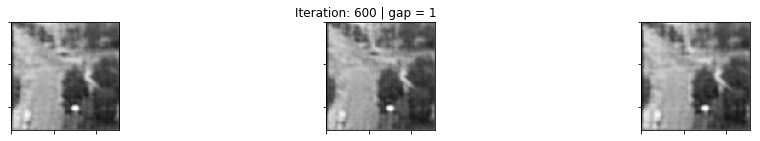

Iteration 600:  loss = 153.22481215000153 | Gap = 3


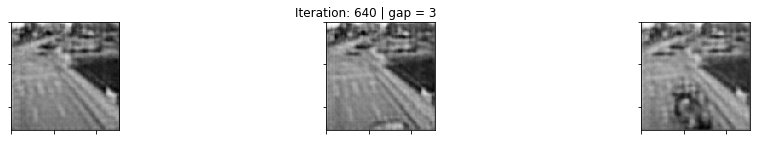

Iteration 640:  loss = 153.08111906051636 | Gap = 1


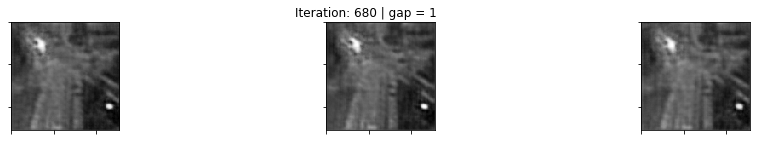

Iteration 680:  loss = 140.8158838748932 | Gap = 1


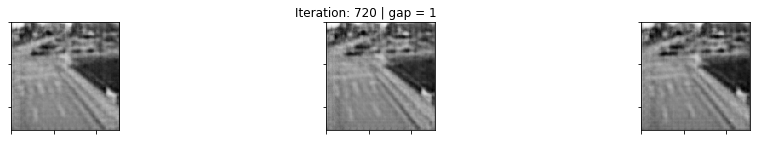

Iteration 720:  loss = 150.33643007278442 | Gap = 3


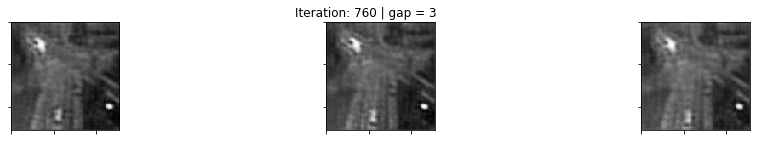

Iteration 760:  loss = 137.54074335098267 | Gap = 1


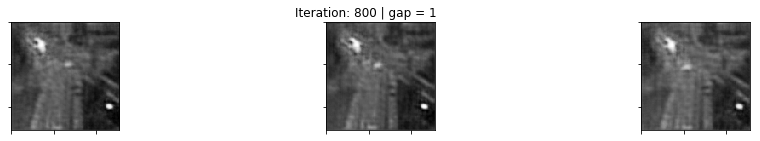

Iteration 800:  loss = 140.2799504995346 | Gap = 3


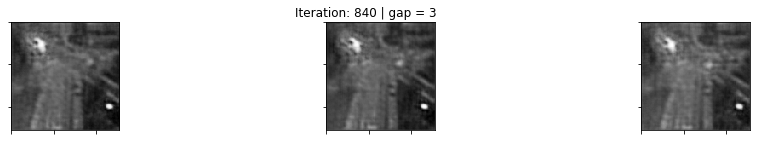

Iteration 840:  loss = 146.50044977664948 | Gap = 3


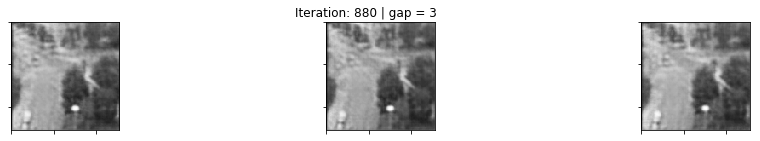

Iteration 880:  loss = 133.64930629730225 | Gap = 1


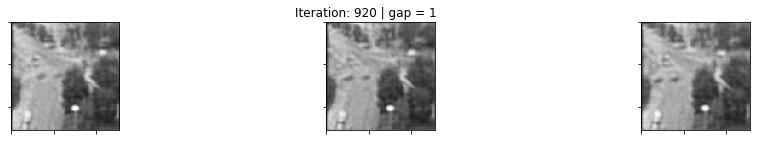

Iteration 920:  loss = 143.20048391819 | Gap = 3


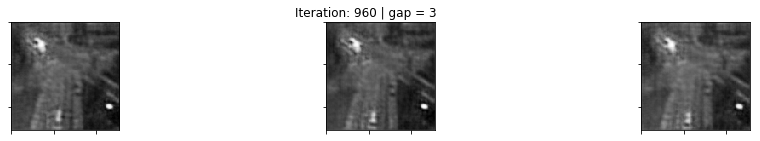

Iteration 960:  loss = 135.20671606063843 | Gap = 1


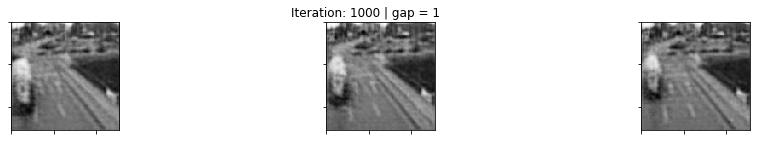

Iteration 1000:  loss = 135.30739545822144 | Gap = 3


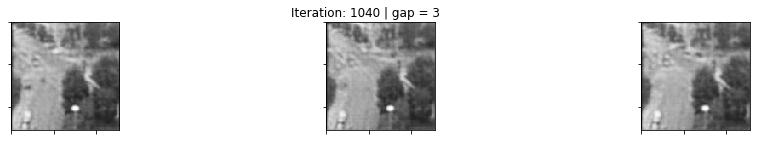

Iteration 1040:  loss = 135.11852025985718 | Gap = 1


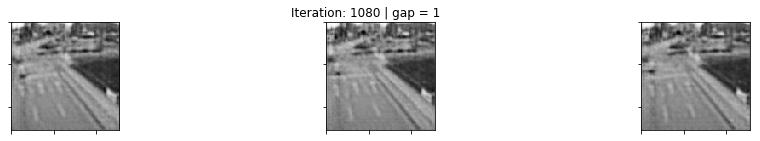

Iteration 1080:  loss = 135.790496468544 | Gap = 1


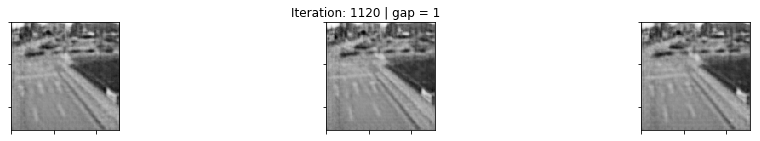

Iteration 1120:  loss = 135.96969485282898 | Gap = 3


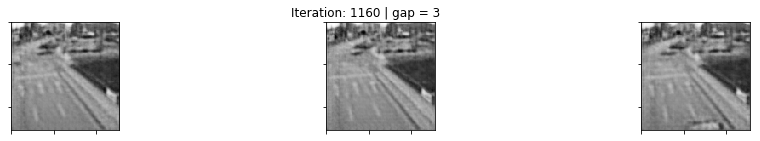

Iteration 1160:  loss = 132.15548992156982 | Gap = 3


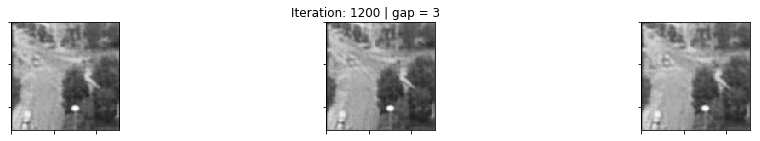

Iteration 1200:  loss = 132.9587060213089 | Gap = 1


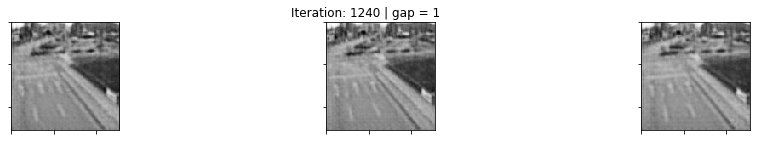

Iteration 1240:  loss = 129.0783542394638 | Gap = 3


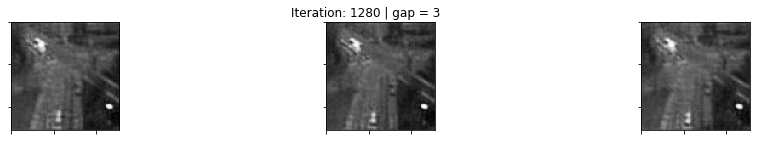

Iteration 1280:  loss = 134.48202908039093 | Gap = 3


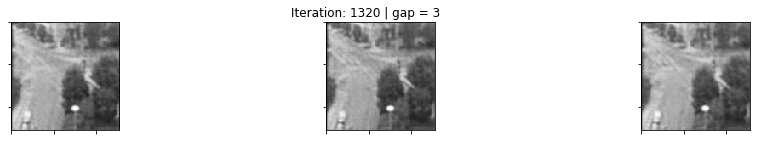

Iteration 1320:  loss = 122.07716405391693 | Gap = 1


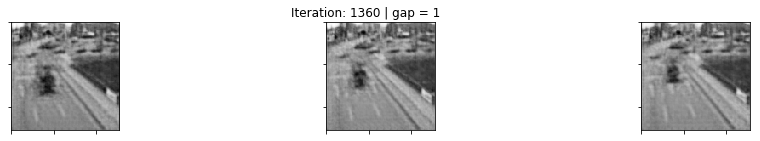

Iteration 1360:  loss = 120.46060919761658 | Gap = 1


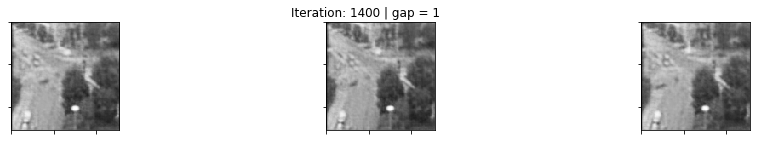

Iteration 1400:  loss = 115.78266501426697 | Gap = 1


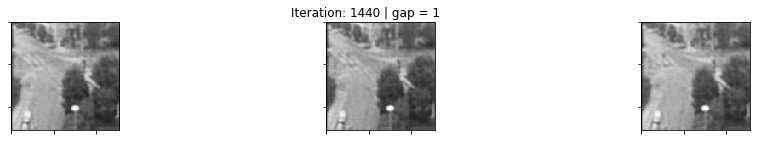

Iteration 1440:  loss = 120.8166754245758 | Gap = 1


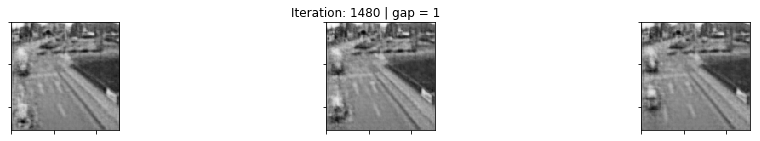

Iteration 1480:  loss = 117.1133941411972 | Gap = 1


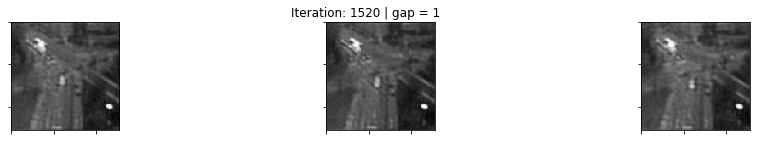

Iteration 1520:  loss = 124.0506261587143 | Gap = 3


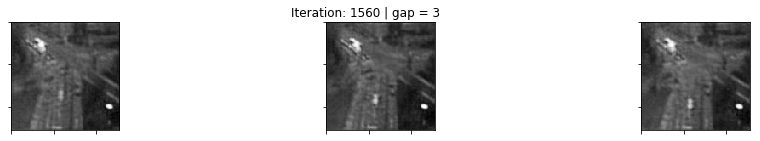

Iteration 1560:  loss = 124.4240802526474 | Gap = 3


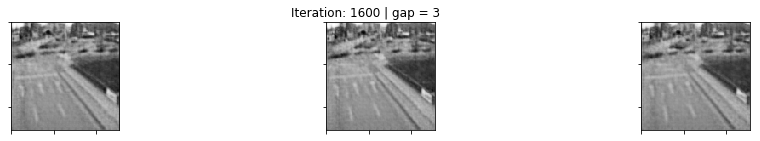

Iteration 1600:  loss = 122.53477096557617 | Gap = 1


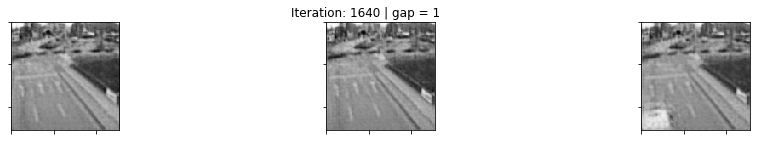

Iteration 1640:  loss = 117.63411819934845 | Gap = 3


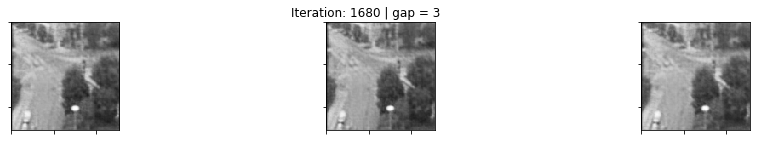

Iteration 1680:  loss = 116.76044881343842 | Gap = 1


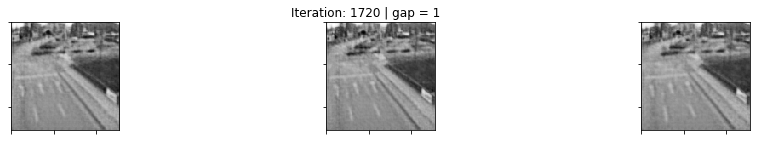

Iteration 1720:  loss = 125.247642993927 | Gap = 3


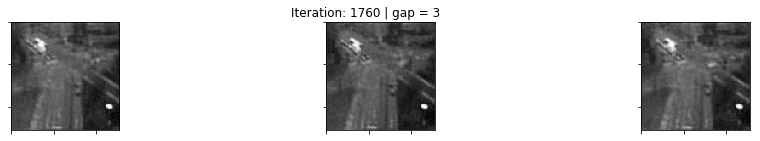

Iteration 1760:  loss = 121.54535472393036 | Gap = 3


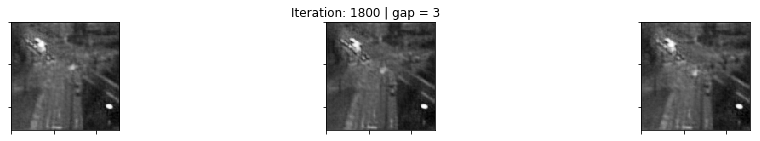

Iteration 1800:  loss = 112.76910245418549 | Gap = 1


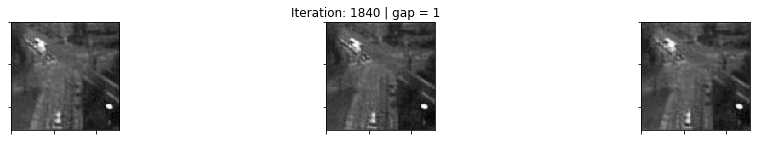

Iteration 1840:  loss = 112.34915912151337 | Gap = 3


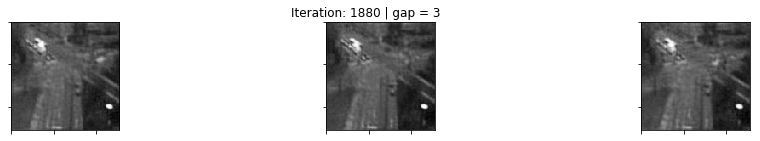

Iteration 1880:  loss = 122.26515769958496 | Gap = 3


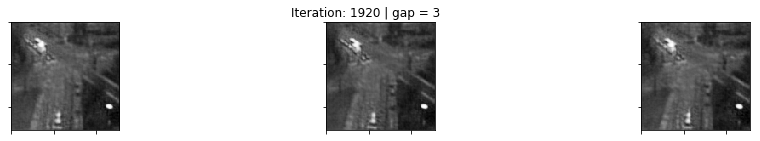

Iteration 1920:  loss = 106.28692388534546 | Gap = 1


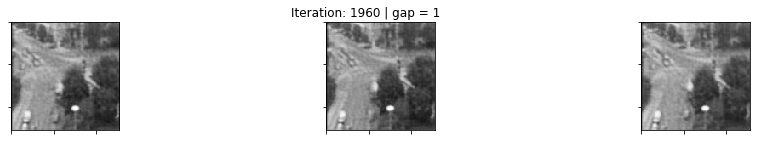

Iteration 1960:  loss = 110.24719297885895 | Gap = 1


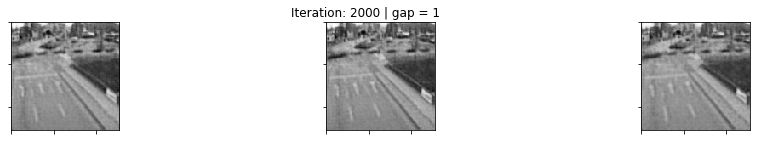

In [104]:
sess = get_session()
sess.run(tf.global_variables_initializer())
losses = train(sess, train_step, loss, batch_size, num_iteration, plot_every = 40, show_loss_every = 40, num_plot=7)

In [107]:
def report_loss(name, num_run = 100, gap = 3, batch_size = batch_size, seq_size = 3):
    losses = []
    for _ in range(num_run):
        if name == "train": seq_input, seq_gd = sample_train(1, gap, seq_size = seq_size)
        else:               seq_input, seq_gd = sample_test(1, gap, seq_size = seq_size)
        dic = {batch_seq: seq_input, batch_next: seq_gd, is_training: True}
        curr_loss = sess.run(loss, dic)
        losses.append(curr_loss)
    return scale_loss(np.mean(losses))

In [108]:
def get_generattion(seq_input):
    feed_dict={batch_seq: seq_input, is_training: False}
    gen_batch = sess.run(output_imgs, feed_dict)
    return gen_batch

In [109]:
def show_generations(name, seq_size = 6, gap = 3):
    if name == "train":  seq_input, seq_gd = sample_train(1, gap, seq_size = seq_size)
    else:                seq_input, seq_gd = sample_test(1, gap, seq_size = seq_size)
    
    seq_generated = get_generattion(seq_input)
    seq_generated, seq_input, seq_gd = seq_generated[0], seq_input[0], seq_gd[0]
    size = (20, 2)
    plot_images_ndarray(seq_input, title="Input Sequence", size = size)
    plot_images_ndarray(seq_gd, title="Next Frames - Ground Truth", size = size)
    plot_images_ndarray(seq_generated, title="Next Frames - Generated", size = size)

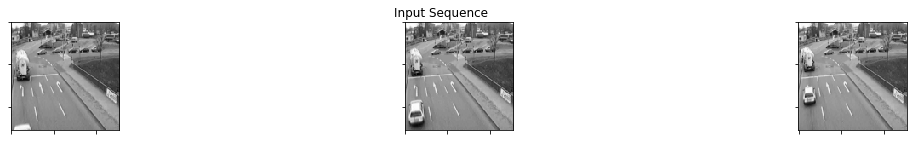

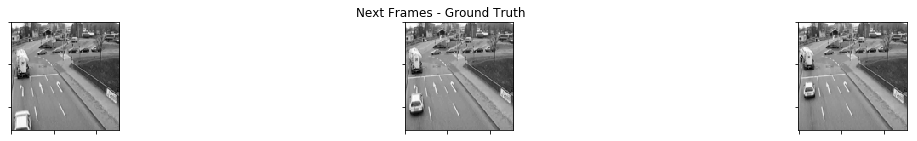

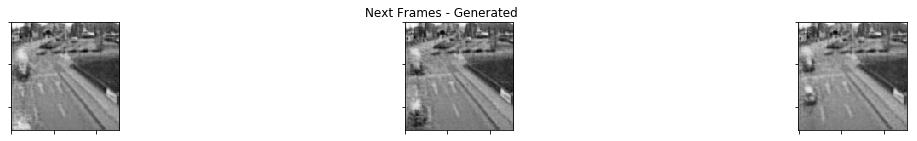

Training Loss = 20.00781625509262


In [156]:
def eval_train(seq_size = 3, gap = 3):
    show_generations("train", seq_size, gap)
    loss = report_loss("train", 100, gap, batch_size, seq_size = seq_size)
    print("Training Loss = {}".format(loss))
    return loss

train_loss = eval_train(seq_size = seq_size, gap = 3)

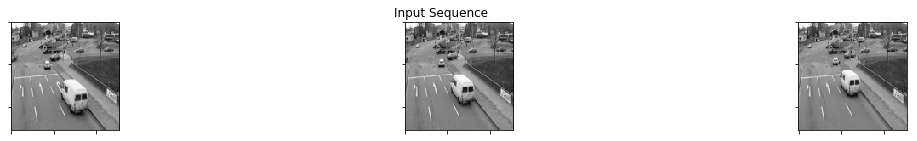

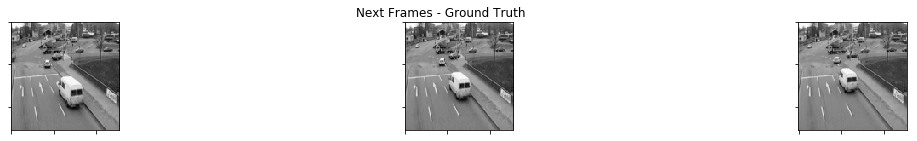

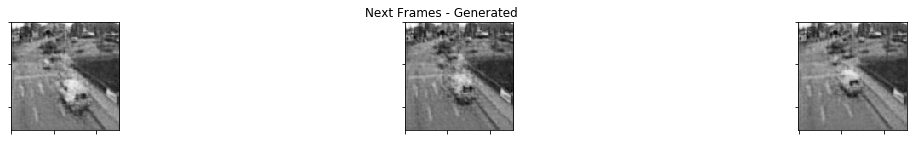

In [165]:
def eval_test(seq_size = 3, gap = 3):
    show_generations("test", seq_size, gap)
#     loss = report_loss("test", 100, gap, batch_size, seq_size = seq_size)
#     print("Test Loss = {}".format(loss))
    return loss

test_loss = eval_test(seq_size = 3, gap = 1)

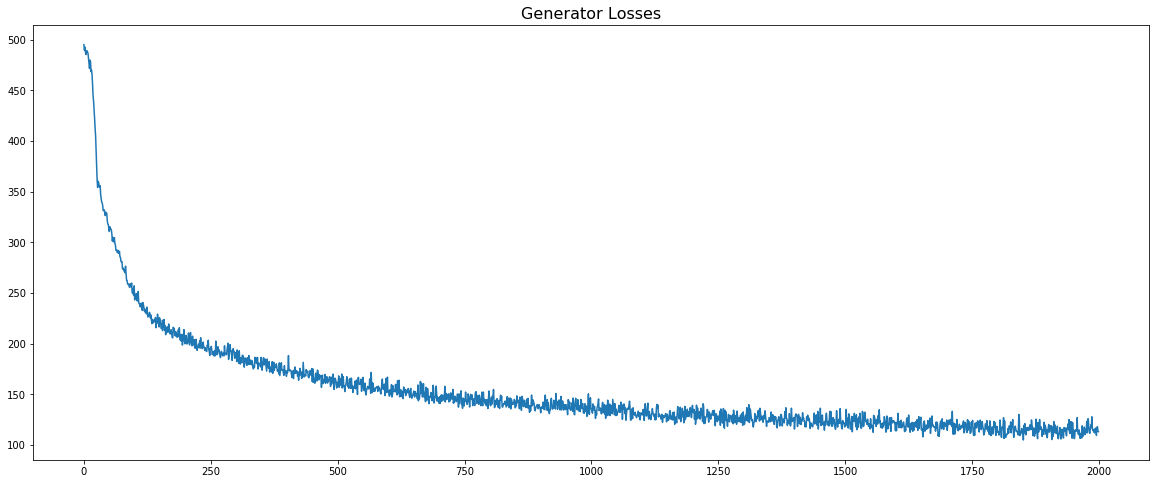

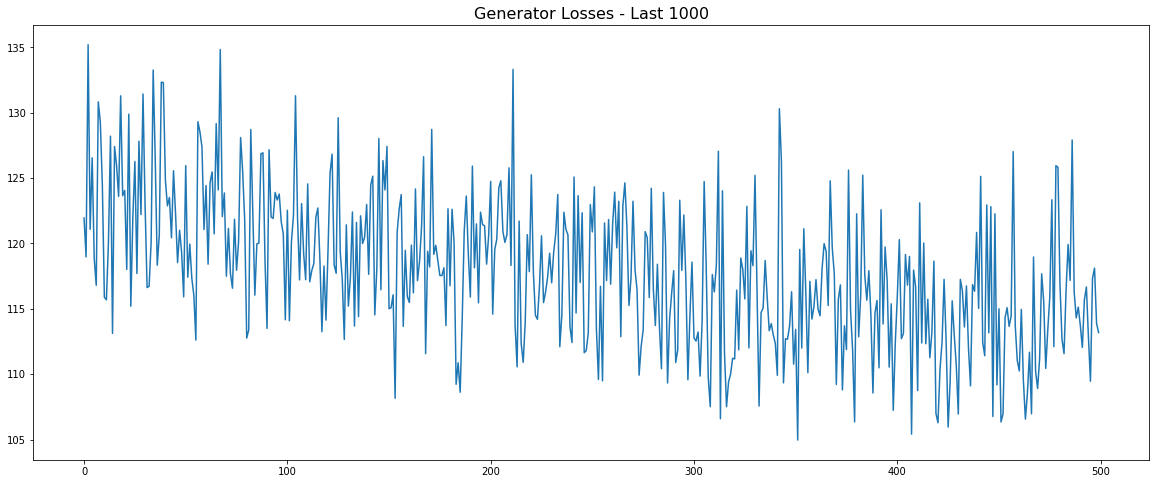

In [113]:
figsize = (20, 8)

plt.figure(figsize=figsize)
plt.plot(losses)
plt.title("Generator Losses", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(losses[-500:])
plt.title("Generator Losses - Last 1000", fontsize=16)
plt.show()

In [29]:
saver = tf.train.Saver()
saver.save(sess, "../trained_model/road-128x128/first-success/", global_step = 2000) 

'../trained_model/road-128x128/first-success/-2000'